### Feature Generation using Technical Indicators

Stocks go up and down erratically. With knowledge of the market and stocks' underlying companies you might be able to explain some of its movement. However, it is extremely difficult to incorporate such information into a computer model. Instead you can use technical indicators to judge a stock's strength based on historical data. Most technical indicators fall into distinct categories. Some use momentum to measure a stock's trajectory. Others use moving averages to look at a longer view of the stock's performance. In this notebook, I will take a look at many of the common technical indicators used by traders.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

[TA-Lib](https://mrjbq7.github.io/ta-lib/) is a library containing over one hundred technical indicators. The Python bindings allow me to quickly generate new features for my model.

In [2]:
import talib as ta

First, the acquired data is returned to DataFrame format.

In [3]:
stocks = pd.read_hdf('../data/raw/market_stocks.h5', key='stocks_2013')

stocks = stocks.reset_index().set_index(['symbol', 'date']).sort_index().reset_index()

The data must be grouped by stock symbol for accurate computation.

In [4]:
stocks_by_symbol = stocks.groupby('symbol')

In [5]:
symbols = stocks.symbol.unique()

Feature columns are generated based on custom inputs. I create a set to avoid duplicates.

In [6]:
COLUMNS = set()

These two helper functions contain the common elements in all of the technical indicators used. They generate the feature column, normalize if required, and add the column(s) to the column set. 


#### Normalization
Not all stocks have the same value, so normalization is required whenever the result is modified by the stock's value. This prevents high value stocks from skewing results. Certain technical indicators are normalized by default.

#### Time Periods
Some technical indicators use a variable number of previous data points to calculate a result. A short time period may have a very different value and meaning from a long time period. 

In [7]:
def technical_indicator(stock, name, func, normalize, *args, **kwargs):
    if 'normalize_by' not in kwargs:
        kwargs['normalize_by'] = args[0]
        
    stock.loc[:, name] = func(*args) / (kwargs['normalize_by'] if normalize else 1)
    COLUMNS.add(name)
    
def technical_indicator_time_periods(stock, name, func, timeperiods, normalize=False, *args, **kwargs):
    if 'normalize_by' not in kwargs:
        kwargs['normalize_by'] = args[0]
    
    for tp in timeperiods:
        column = f'{name}_{tp}'
        stock.loc[:, column] = func(*args, timeperiod=tp) / (kwargs['normalize_by'] if normalize else 1)
        COLUMNS.add(column)

In [8]:
google = stocks_by_symbol.get_group('AAPL').set_index('date')

## Overlap Studies

Overlap studies use moving averages to measure stock performance. The term overlap refers to periods in time when the stock price "overlaps" with a particular moving average. This may indicate a time to buy or sell a stock depending on the direction of movement.

### Bollinger Bands

The Bollinger Bands are probably the most well known technical indicators. They consist of three features. The upper and lower bands represents (by default) one standard deviation above and below the middle band. The middle band is a simple moving average of the stock price, but can be modified to use other types of moving averages. 

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


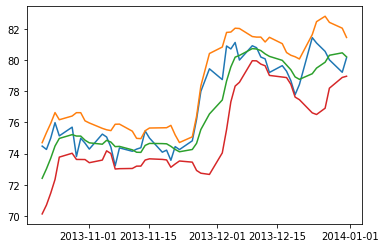

In [9]:
upper, middle, lower = ta.BBANDS(google.close, timeperiod=5)

plt.plot(google.close[-50:])
plt.plot(upper[-50:])
plt.plot(middle[-50:])
_ = plt.plot(lower[-50:])

In [10]:
def bollinger_bands(stock, timeperiods, close):
    for tp in timeperiods:
        column_upper = f'bb_upper_{tp}'
        column_middle = f'bb_middle_{tp}'
        column_lower = f'bb_lower_{tp}'
        column_width = f'bb_width_{tp}'
        
        upper, middle, lower = ta.BBANDS(close, timeperiod=tp)
        
        stock.loc[:, column_upper] = upper / close
        stock.loc[:, column_middle] = middle / close
        stock.loc[:, column_lower] = lower / close
        stock.loc[:, column_width] = (upper - lower) / close
        
        COLUMNS.update([column_upper, column_middle, column_lower, column_width])

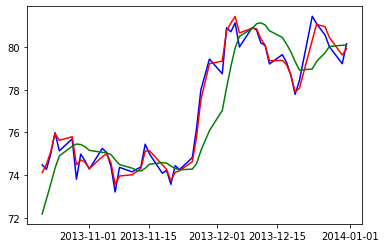

In [11]:
tema = ta.TEMA(google.close, timeperiod=5)
t3 = ta.T3(google.close, timeperiod=5, vfactor=0.7)

plt.plot(google.close[-50:], c='b')
plt.plot(tema[-50:], c='r')
plt.plot(t3[-50:], c='g')

In [12]:
def triple_exponential_moving_average(stock, timeperiods, close):
    technical_indicator_time_periods(stock, 'tema', ta.TEMA, timeperiods, True, close)

In [13]:
def triple_exponential_moving_average_t3(stock, timeperiods, close):
    for tp in timeperiods:
        column = f't3_{tp}'
        stock.loc[:, column] = ta.T3(close, timeperiod=tp, vfactor=0.7) / close
        COLUMNS.add(column)

## Momentum Indicators

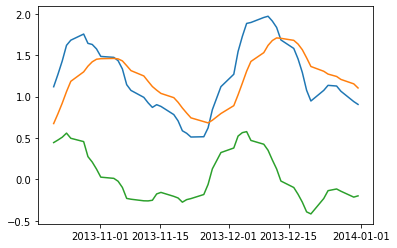

In [14]:
line, hist, signal = ta.MACD(google.close)

plt.plot(line[-50:])
plt.plot(hist[-50:])
plt.plot(signal[-50:])

In [15]:
def moving_average_convergence_divergence(stock, close):
    line, hist, signal = ta.MACD(close)

    stock.loc[:, 'macd_line'] = line
    stock.loc[:, 'macd_hist'] = hist
    stock.loc[:, 'macd_signal'] = signal

    COLUMNS.update(['macd_line', 'macd_hist', 'macd_signal'])

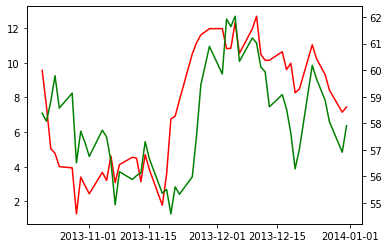

In [16]:
mom = ta.MOM(google.close, timeperiod=50)
rsi = ta.RSI(google.close, timeperiod=50)

fig, ax = plt.subplots()

ax.plot(mom[-50:], c='r')

ax2 = ax.twinx()

ax2.plot(rsi[-50:], c='g')

In [17]:
def momentum(stock, timeperiods, close):
    technical_indicator_time_periods(stock, 'mom', ta.MOM, timeperiods, True, close)

In [18]:
def relative_strength_index(stock, timeperiods, close):
    technical_indicator_time_periods(stock, 'rsi', ta.RSI, timeperiods, False, close)

## Volume Indicators

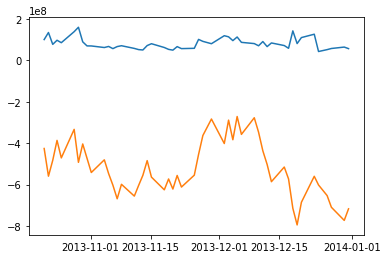

In [19]:
obv = ta.OBV(google.close, google.volume)

plt.plot(google.volume[-50:])
plt.plot(obv[-50:])

In [20]:
def on_balance_volume(stock, close, volume):
    technical_indicator(stock, 'obv', ta.OBV, True, close, volume, normalize_by=volume)

## Volatility Indicators

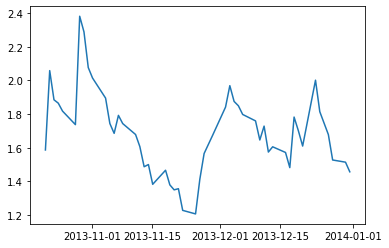

In [21]:
natr = ta.NATR(google.high, google.low, google.close, timeperiod=5)

plt.plot(natr[-50:])

In [22]:
def normalized_average_true_range(stock, timeperiods, high, low, close):
    technical_indicator_time_periods(stock, 'natr', ta.NATR, timeperiods, False, high, low, close)

## Price Transform

In [23]:
def median_price(stock, high, low, close):
    technical_indicator(stock, 'median_price', ta.MEDPRICE, True, high, low, normalize_by=close)

In [24]:
def weighted_close_price(stock, high, low, close):
    technical_indicator(stock, 'wcl_price', ta.WCLPRICE, True, high, low, close, normalize_by=close)

## Statistic Functions

In [25]:
def linear_regression(stock, timeperiods, close):
    technical_indicator_time_periods(stock, 'linear_regression', ta.LINEARREG, timeperiods, True, close)
    technical_indicator_time_periods(stock, 'linear_regression_angle', ta.LINEARREG_ANGLE, timeperiods, False, close)
    technical_indicator_time_periods(stock, 'linear_regression_intercept', ta.LINEARREG_INTERCEPT, timeperiods, True, close)
    technical_indicator_time_periods(stock, 'linear_regression_slope', ta.LINEARREG_SLOPE, timeperiods, True, close)

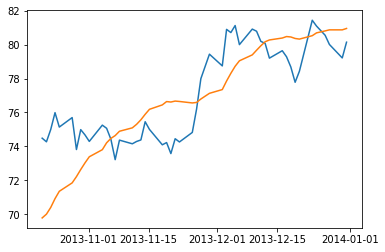

In [26]:
tsf = ta.TSF(google.close, timeperiod=50)

plt.plot(google.close[-50:])
plt.plot(tsf[-50:])

In [27]:
def time_series_forecast(stock, timeperiods, close):
    technical_indicator_time_periods(stock, 'tsf', ta.TSF, timeperiods, True, close)

## Compute Indicators

In [28]:
def compute_indicators(stock, market):
    
    stock = stock.copy()
    
    if market:
        open_ = stock.loc[:, 'open_market']
        high = stock.loc[:, 'high_market']
        low = stock.loc[:, 'low_market']
        close = stock.loc[:, 'close_market']
        volume = stock.loc[:, 'volume_market']
    else:
        open_ = stock.loc[:, 'open']
        high = stock.loc[:, 'high']
        low = stock.loc[:, 'low']
        close = stock.loc[:, 'close']
        volume = stock.loc[:, 'volume']
    
    timeperiods = [5, 20]
    
    # Overlap Studies
    
    bollinger_bands(stock, timeperiods, close)
        
    triple_exponential_moving_average(stock, timeperiods, close)
                        
    triple_exponential_moving_average_t3(stock, timeperiods, close)
    
    # Momentum Indicators
             
    moving_average_convergence_divergence(stock, close)
    
    momentum(stock, timeperiods, close)
    
    relative_strength_index(stock, timeperiods, close)
        
    # Volume Indicators
        
    on_balance_volume(stock, close, volume)
    
    # Volatility Indicators
        
    normalized_average_true_range(stock, timeperiods, high, low, close)
    
    # Price Transform
    
    median_price(stock, high, low, close)
    
    weighted_close_price(stock, high, low, close)
            
    # Statistic Functions
            
    linear_regression(stock, timeperiods, close)
        
    time_series_forecast(stock, timeperiods, close)
        
    if not market:
        # Forecast
        stock.loc[:, 'forecast'] = -close.diff(-1) / close

        # Buy Signal
        stock.loc[:, 'buy_signal'] = (stock.loc[:, 'forecast'] > 0).astype(float)
    
    return stock

In [29]:
groups = np.empty(len(symbols), dtype=object)

for i, symbol in tqdm(enumerate(symbols)):
    groups[i] = stocks_by_symbol.get_group(symbol)

In [30]:
stocks = np.empty(len(groups), dtype=object)

for i, group in tqdm(enumerate(groups)):
    stocks[i] = compute_indicators(group, False)

In [31]:
stocks = pd.concat(stocks).replace([np.inf, -np.inf], np.nan).dropna()

In [32]:
market = np.empty(len(groups), dtype=object)

for i, group in tqdm(enumerate(groups)):
    market[i] = compute_indicators(group, True)

In [33]:
market = pd.concat(market).replace([np.inf, -np.inf], np.nan).dropna()

In [34]:
stocks = stocks.merge(market, on=['symbol', 'date'], suffixes=['', '_market'])

In [35]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest

In [36]:
stocks.set_index('date', inplace=True)

In [37]:
COLUMNS = list(COLUMNS)

In [38]:
COLUMNS += [col + '_market' for col in COLUMNS]

In [39]:
# def plot_classifier(clf, X_train, y_train, X_test, y_test):    
    
#     y_pred_train = clf.predict_proba(X_train)[:, 1]
#     fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
#     y_pred = clf.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_pred)
    
#     plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
#     plt.plot(fpr_train, tpr_train, label='Training Data')
#     plt.plot(fpr, tpr, label='Testing Data')
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend()
#     plt.show()
     
#     print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}')
#     print(f'Test AUC: {roc_auc_score(y_test, y_pred)}')
#     print(f'Test Accuracy: {accuracy_score(y_test, clf.predict(X_test))}')

In [40]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
# from imblearn.under_sampling import RandomUnderSampler

# X = stocks[COLUMNS]
# y = stocks['buy_signal']
    
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [41]:
# rus = RandomUnderSampler()
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [42]:
# from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# scaler = QuantileTransformer(output_distribution='normal')
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [43]:
# from xgboost import XGBClassifier

# clf = XGBClassifier(n_jobs=-1, verbosity=1)

# clf.fit(X_train_scaled, y_train)

# plot_classifier(clf, X_train_scaled, y_train, X_test_scaled, y_test)

In [44]:
# importances = clf.feature_importances_
# indices = np.argsort(importances)[::-1]
# [(COLUMNS[i], importances[i]) for i in indices]

In [45]:
import json

with open('../models/columns.json', 'w+') as column_file:
    json.dump(list(COLUMNS), column_file)

In [46]:
stocks[['symbol', 'close'] + COLUMNS + ['buy_signal', 'forecast']].to_hdf('../data/clean/computed_stocks.h5', key='stocks_2013')